In [378]:
import pandas as pd
import numpy as np
import datajoint as dj
from ibl_pipeline import subject, acquisition, behavior, histology
ephys = dj.create_virtual_module('ephys', 'ibl_ephys')
from brainbox.singlecell import singlecell
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian
import seaborn as sns

In [348]:
def CSK_PSTH(trials, pre_time=0.2, post_time=0.5, bin_size=0.025, smoothing=0.025):
    """
    A PSTH function that relies on the datajoint data format returned by quieries containing ephys.AlignedTrialSpikes 
    trials: (array-like) trial_spike_times returned by the above mentrioned query (event is always at 0 seconds) 
    others are PSTH parameters
    
    """
    n_bins = round((pre_time+post_time)/bin_size)
    event_idx = round(pre_time/bin_size)
    all_counts = np.zeros([n_bins,len(trials)])
    
    if smoothing > 0: # build gaussian window for smoothing
        w = n_bins - 1 if n_bins % 2 == 0 else n_bins
        window = gaussian(w, std=smoothing / bin_size)
        # half (causal) gaussian filter
#         window[int(np.ceil(w/2)):] = 0
        window /= np.sum(window)
#         binned_spikes_conv = np.copy(binned_spikes)
        

    for i in range(len(trials)):        
        counts, bins = np.histogram(trials.trial_spike_times.iloc[i],bins=n_bins,range=[-pre_time,post_time])
        all_counts[:,i] = counts
    PSTH = all_counts.mean(axis=1)
    smooth_PSTH = convolve(PSTH,window,mode='same')
    return smooth_PSTH, event_idx

In [377]:
def vis_PSTH_from_dj(spike_times, cluster_ids, event, contrasts, alpha=.001, pre_time=0,
        post_time=0.2, bin_size=0.01, smoothing=0.01, FR_cutoff = .1):
    """
    function to find if a neuron is visual based on its PSTH. compares the PSTH of a cluster for left, right, or 
    no visual stimulus, if there is a significant difference between both left and right and zero contrast, then 
    considered visual (using alpha value above.)
    spike_times: (array-like) trial_spike_times returned by the above mentrioned query (event is always at 0 seconds) 
    cluster_ids: (array-like) len of spike_times, ID of the cluster
    event : event alligning to
    contrasts : signed contrast of the stimulus
    alpha: significance level for K-S test
    others: PSTH params
    
    returns: 
        a dataframe of significant clusters, with cluster_id, the PSTH values for left, right, and zero stimuli
             and the allen label for the brain_area that the cluster is located in
        a list of all the brain areas of all the clusters, one label per area, used to find what proportion of 
        neurons in an area are

    """
    
    sigClusters = pd.DataFrame(columns=['cluster_id','left_PSTH', 'right_PSTH','zero_PSTH', 'brain_area'])
    u_clusters = np.unique(cluster_ids)
    u_contrasts = np.unique(contrasts)
    alpha = .01
    p1s = []
    p2s = []
    count = 0
    sig_clu = []
    sig_left = []
    sig_right = []
    sig_zero = []
    sig_region = []
    all_region = []
    

    for cluster in u_clusters: # loop over clusters to create PSTHs for each
        clust_idx = np.where(cluster_ids == cluster)[0]
        trials = data.iloc[clust_idx]
        area = trials.acronym.iloc[0]
        # break down by stimulus side so I can see which cells have higher activity for stim vs 0 contrast
        left_trials =np.where(trials.signedContrast < 0)[0]
        right_trials = np.where(trials.signedContrast > 0)[0]
        zero_trials = np.where(trials.signedContrast == 0)[0]
        left_PSTH, event_idx = CSK_PSTH(trials.iloc[left_trials],pre_time=pre_time,post_time=post_time,bin_size=bin_size,smoothing=smoothing)
        right_PSTH, event_idx = CSK_PSTH(trials.iloc[right_trials],pre_time=pre_time,post_time=post_time,bin_size=bin_size,smoothing=smoothing)
        zero_PSTH, event_idx = CSK_PSTH(trials.iloc[zero_trials],pre_time=pre_time,post_time=post_time,bin_size=bin_size,smoothing=smoothing)
        _, p1 = ks_2samp(left_PSTH,zero_PSTH)# Kolmogorov-Smirnov test to see if either is more active than zero contrast
        _, p2 = ks_2samp(right_PSTH,zero_PSTH)
        _, p3 = ks_2samp(right_PSTH,left_PSTH)
        if (p1 < alpha or p2 < alpha) and p3 < alpha: #and (np.any(left_PSTH>FR_cutoff) or np.any(right_PSTH>FR_cutoff)):
            sig_clu.append(cluster)
            sig_left.append(left_PSTH)
            sig_right.append(right_PSTH)
            sig_zero.append(zero_PSTH)
            sig_region.append(area)
        #if (np.any(left_PSTH>FR_cutoff) or np.any(right_PSTH>FR_cutoff)):
        all_region.append(area) # save the name of all regions, this way a count of the regions will give a number of all clusters recorded in that region, from this I can reconstruct the frac significant per brain area
    sigClusters.cluster_id = sig_clu
    sigClusters.left_PSTH = sig_left
    sigClusters.right_PSTH = sig_right
    sigClusters.zero_PSTH = sig_zero
    brain_areas = group_cortical(sig_region)
    sigClusters.brain_area = brain_areas
    
    return sigClusters, all_region

In [381]:
def group_cortical(areas):
    """
    input areas: a list of brain area names from the allen ontology
    output: that same list with the layers removed from all cortical areas
    """
    exclude = ['1','2/3','4','5','6a','6b']
    for i,area in enumerate(areas):
        for num in exclude:
            if area == 'CA1':
                continue
            elif num in area:
                new_name = area.replace(num,'')
                areas[i]=new_name
    return areas

In [350]:
sig, all_areas = vis_PSTH_from_dj(data.trial_spike_times, data.cluster_id, data.event, data.signedContrast, alpha = .001)
len(sig.left_PSTH[0])

20

In [353]:
# find all subjects with ephys_aligned_histology
hist_subs = histology.ProbeTrajectory * subject.Subject & 'insertion_data_source = "Histology track"'
subs = hist_subs.fetch('subject_nickname')
subs = np.unique(subs)

/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/datajoint/connection.py:218: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


In [354]:
sigs2 = []
all_all_areas2 = []
for sub in subs:
    print('working on subject: {}'.format(sub))
    temp = (ephys.AlignedTrialSpikes & 'event = "stim on"') * (subject.Subject & 'subject_nickname = "{}"'.format(sub)) * behavior.TrialSet.Trial * (ephys.GoodCluster & 'is_good = "1"') * histology.ClusterBrainRegion & 'insertion_data_source = "Histology track"' 
    stimons = temp & 'event= "stim on"'
    if len(stimons) > 0:
        data = pd.DataFrame(stimons.fetch('subject_uuid', 'session_start_time', 'probe_idx', 'cluster_id',
               'trial_id', 'event', 'trial_spike_times', 'trial_spikes_ts',
               'subject_nickname','trial_start_time', 'trial_end_time','trial_stim_on_time',
               'trial_stim_contrast_left', 'trial_stim_contrast_right','acronym', as_dict=True))
        data['signedContrast'] = data.trial_stim_contrast_left - data.trial_stim_contrast_right
        sig, all_areas = vis_PSTH_from_dj(data.trial_spike_times, data.cluster_id, data.event, data.signedContrast, alpha = .001)
        sigs2.append(sig)
        all_all_areas2.append(all_areas)

working on subject: CSHL028
working on subject: CSHL045
working on subject: CSHL046
working on subject: CSHL047
working on subject: CSHL049
working on subject: CSHL050
working on subject: CSHL051
working on subject: CSHL052


/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice.
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


working on subject: CSHL053


/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/datajoint/connection.py:218: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


working on subject: CSHL054
working on subject: CSHL055
working on subject: CSHL_020
working on subject: CSH_ZAD_001
working on subject: CSH_ZAD_013
working on subject: CSH_ZAD_017
working on subject: CSH_ZAD_021
working on subject: CSH_ZAD_022
working on subject: CSH_ZAD_024
working on subject: CSP001
working on subject: CSP003
working on subject: CSP004
working on subject: DY_006
working on subject: DY_008
working on subject: DY_009
working on subject: DY_010
working on subject: DY_011
working on subject: DY_013
working on subject: DY_014
working on subject: KS003
working on subject: KS013
working on subject: KS014
working on subject: KS016
working on subject: KS020
working on subject: KS022
working on subject: KS023
working on subject: NYU-08
working on subject: NYU-11
working on subject: NYU-12
working on subject: SH002
working on subject: SH004
working on subject: SH006
working on subject: SH008
working on subject: SH011
working on subject: SH012
working on subject: SH013
working 

In [355]:
sig_df = pd.concat(sigs2)
all_ba = [y for x in all_all_areas2 for y in x]
u,uc = np.unique(sig_df.brain_area,return_counts=True)

proportion_vis = pd.DataFrame(columns=['area','prop_vis','num_neur'])
prop = []
areas = []
neurs = []
for i,area in enumerate(u):
    num = np.sum(np.array(all_ba) == area)
    prop.append(uc[i]/num)
    areas.append(area)
    neurs.append(num)
proportion_vis['area']=areas
proportion_vis['prop_vis'] = prop
proportion_vis['num_neur'] = neurs
proportion_vis

In [366]:
# np.unique(sig_df.subject_nickname,return_counts=True)
proportion_vis = pd.DataFrame(columns=['area','prop_vis','num_neur'])
prop = []
areas = []
neurs = []
for i,area in enumerate(u):
    num = np.sum(np.array(all_ba) == area)
    prop.append(uc[i]/num)
    areas.append(area)
    neurs.append(num)
proportion_vis['area']=areas
proportion_vis['prop_vis'] = prop
proportion_vis['num_neur'] = neurs
sns.barplot(data=proportion_vis,y='prop_vis',x='area')


area  prop_vis  num_neur
0      ACAd5  0.080000        25
1     ACAd6a  0.060976        82
2     ACAd6b  0.500000         2
3      ACAv1  0.333333         3
4    ACAv2/3  0.027778        36
..       ...       ...       ...
147     rust  0.142857        14
148     scwm  0.069767        43
149     tspc  0.027778        36
150     void  0.125000         8
151      vtd  0.250000         4

[152 rows x 3 columns]

/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


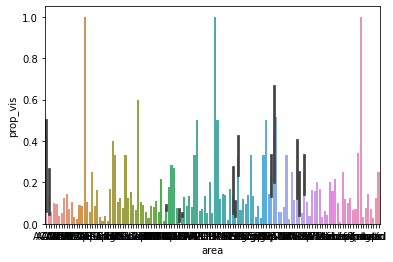

In [382]:
new_labels = group_cortical(proportion_vis.area)
proportion_vis.area = new_labels
sns.barplot(data=proportion_vis,y='prop_vis',x='area')

/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarnin

/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarnin

/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarnin

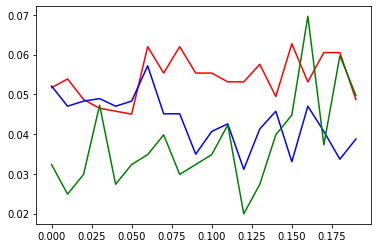

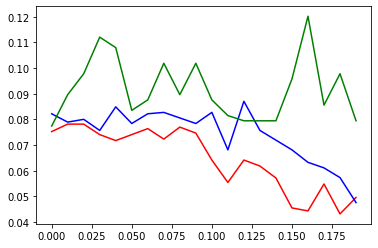

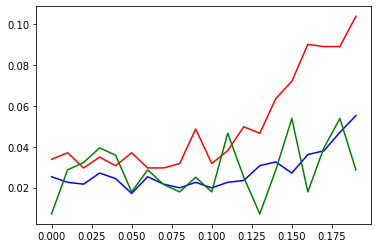

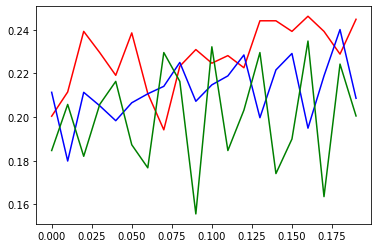

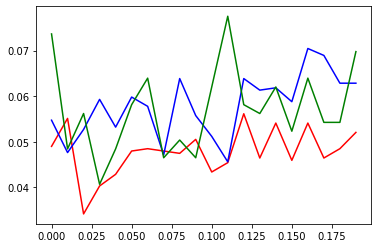

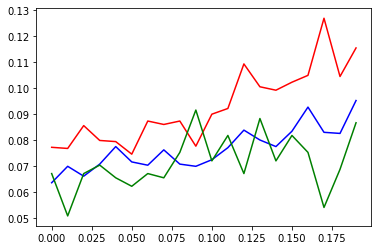

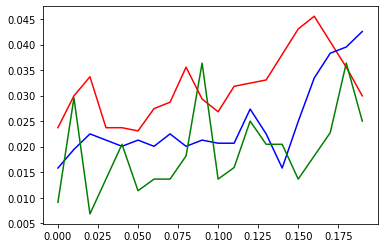

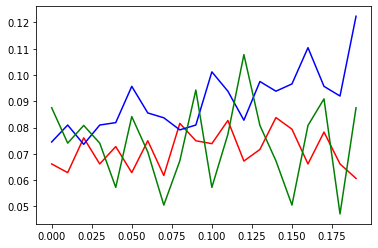

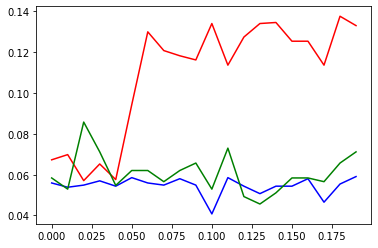

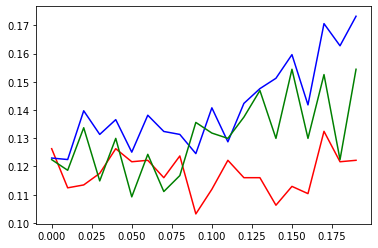

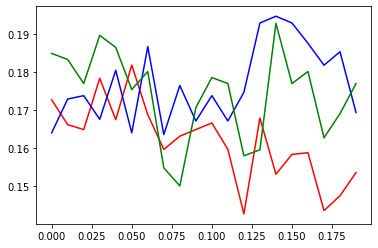

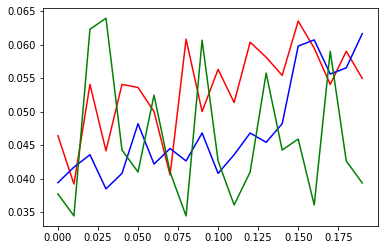

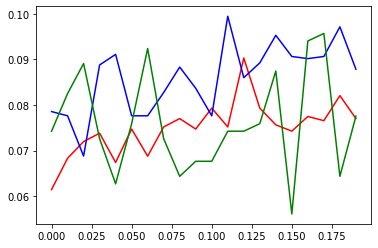

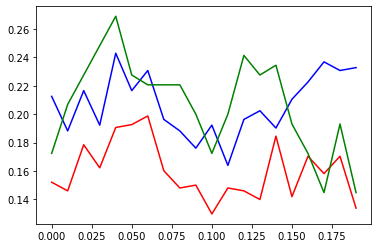

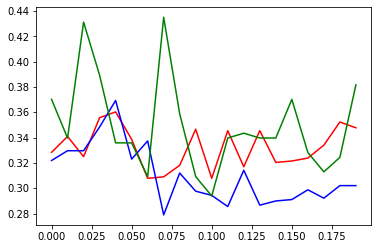

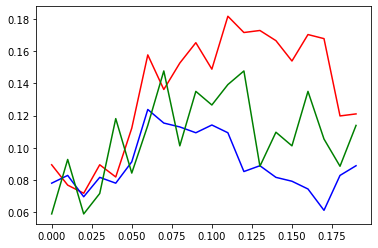

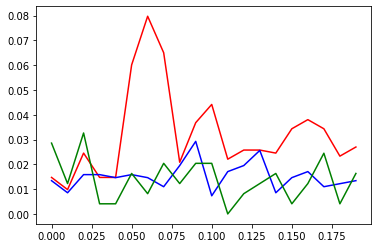

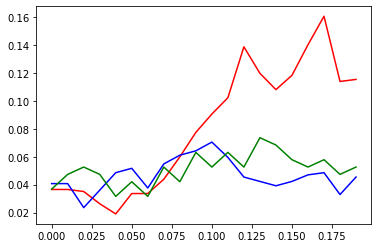

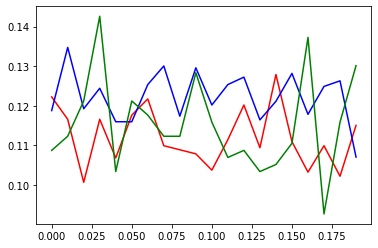

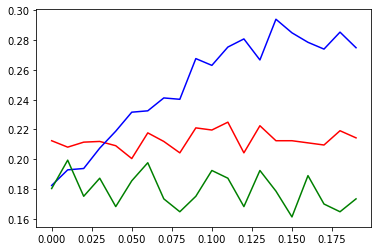

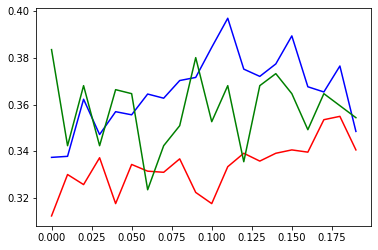

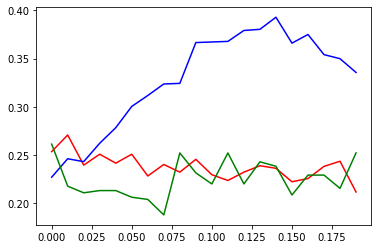

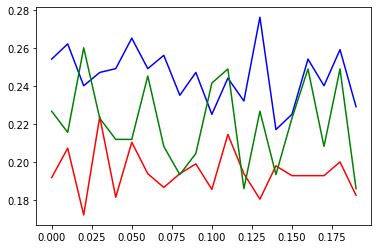

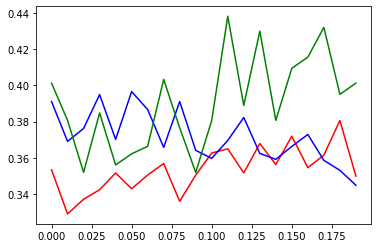

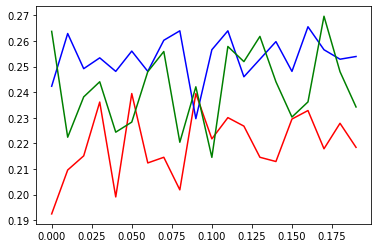

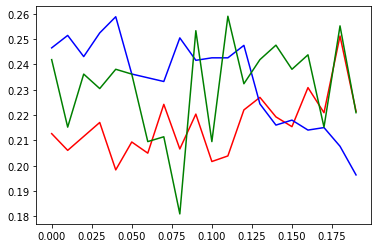

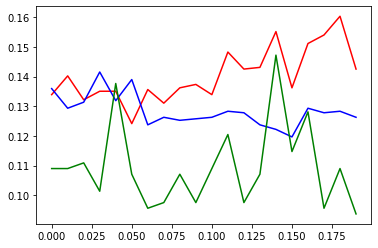

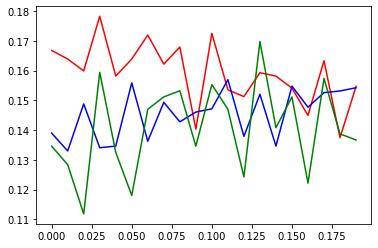

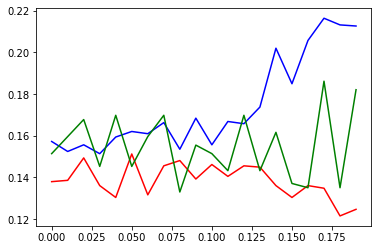

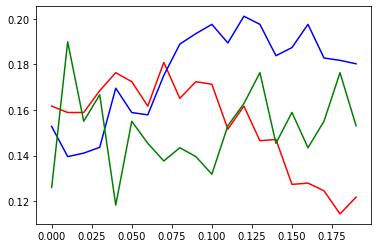

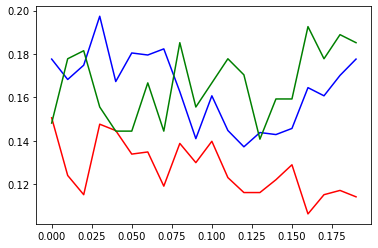

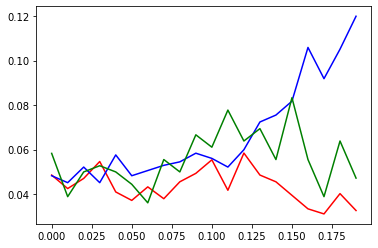

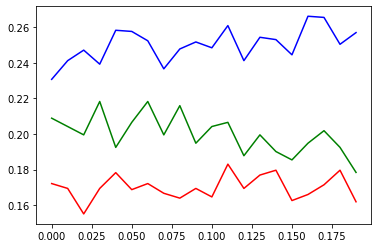

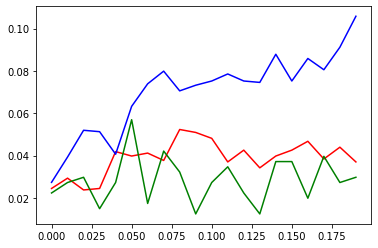

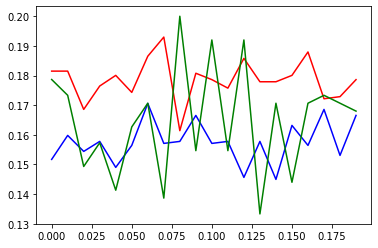

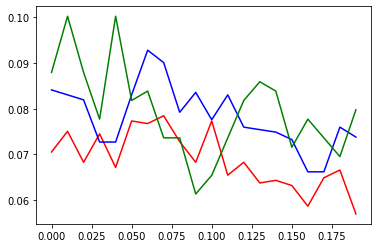

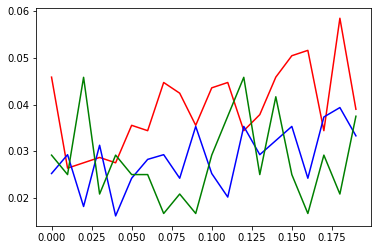

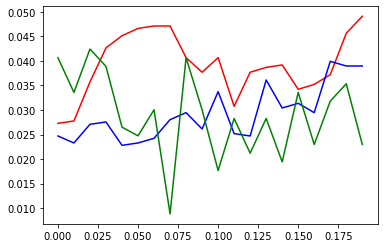

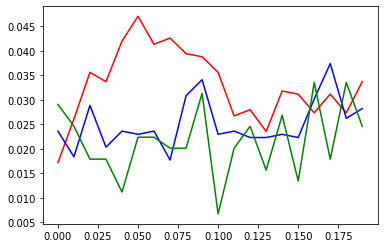

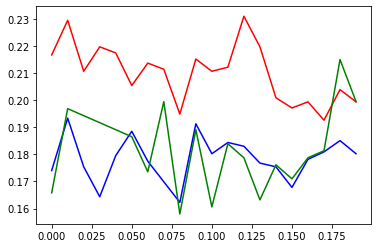

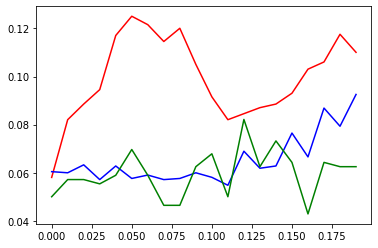

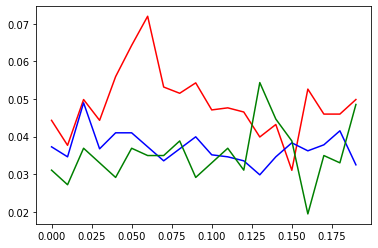

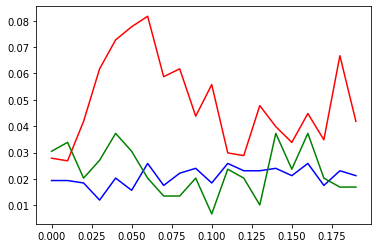

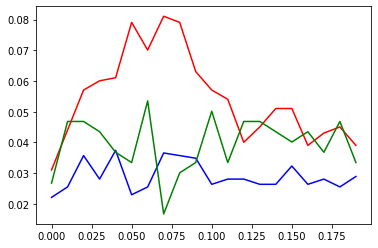

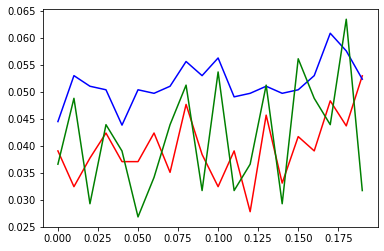

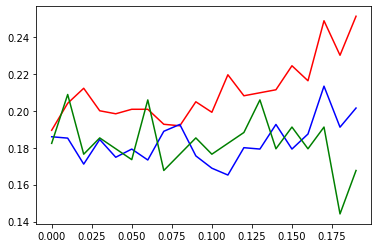

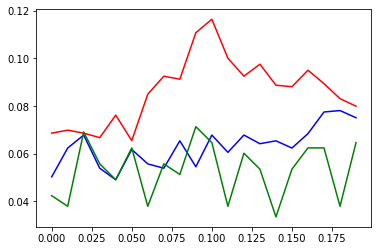

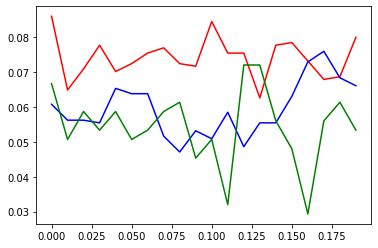

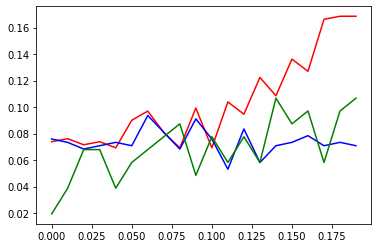

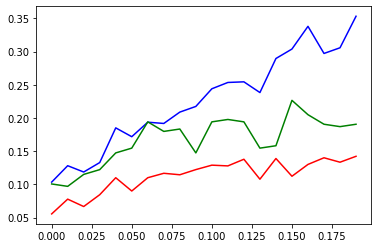

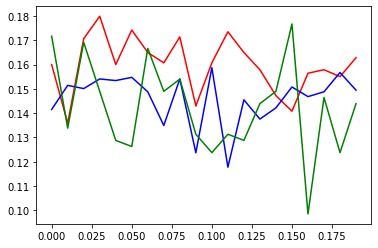

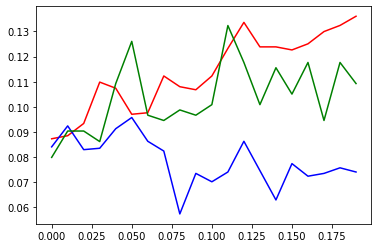

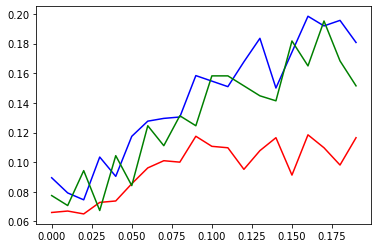

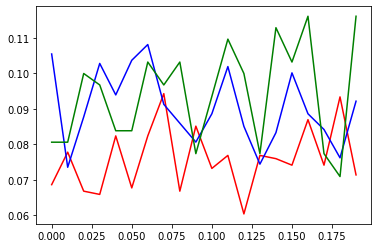

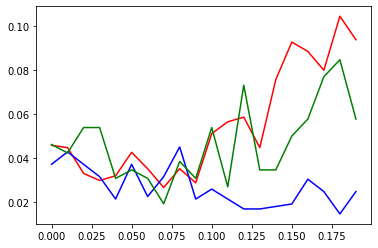

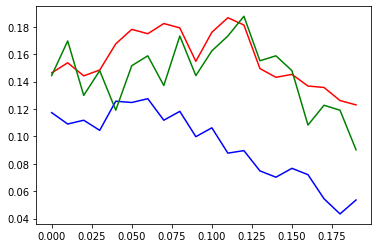

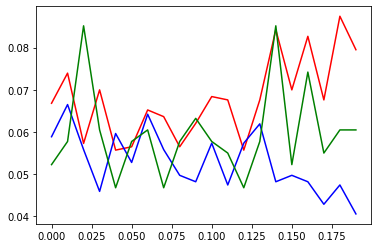

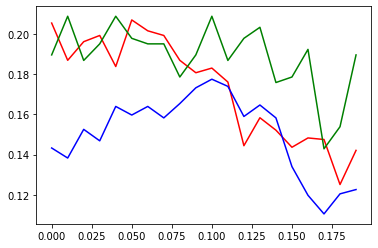

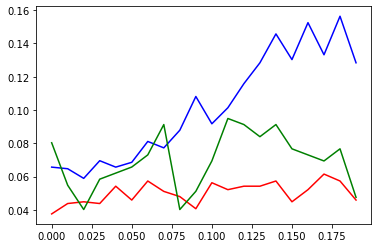

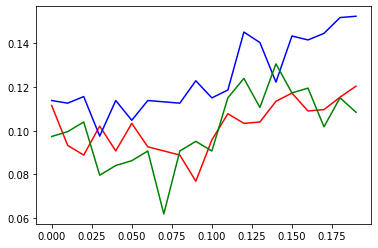

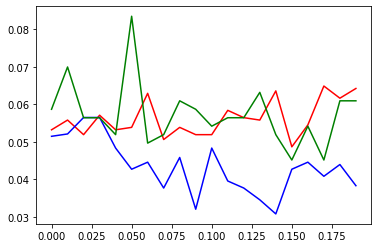

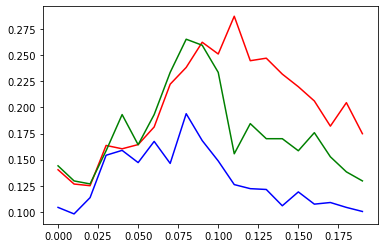

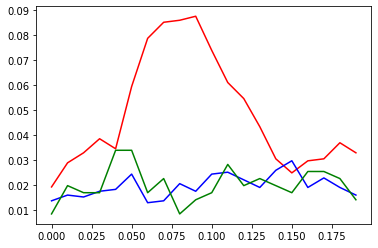

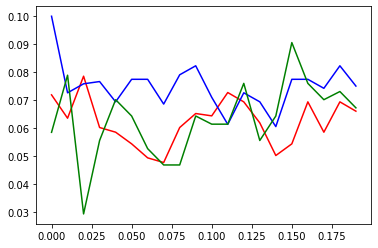

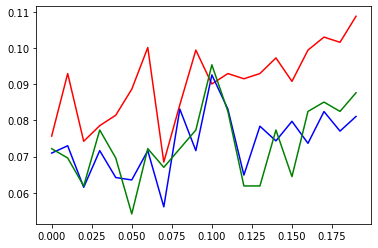

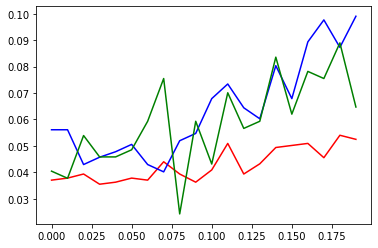

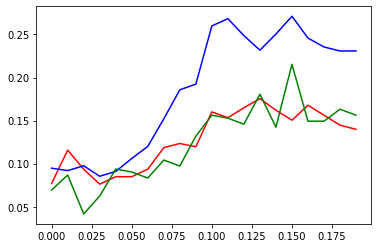

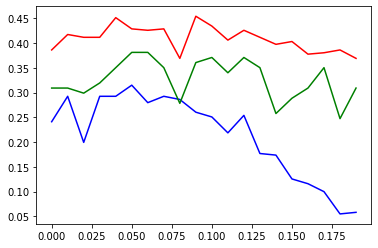

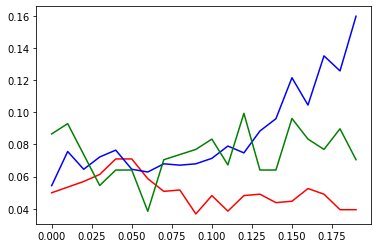

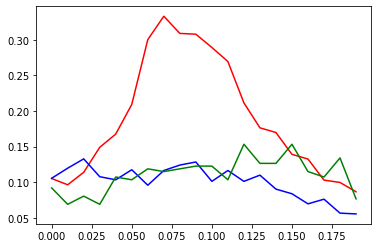

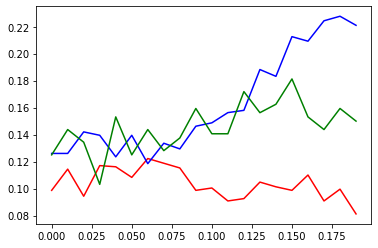

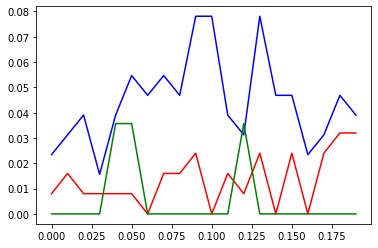

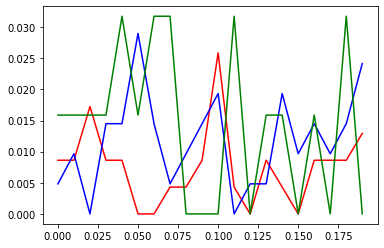

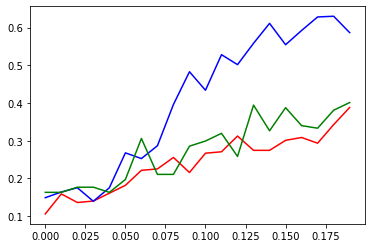

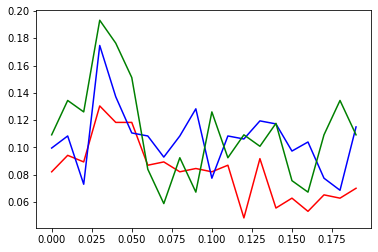

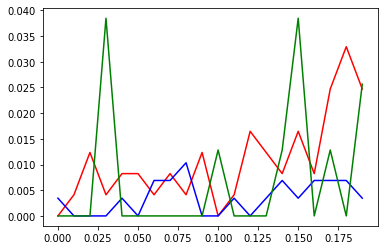

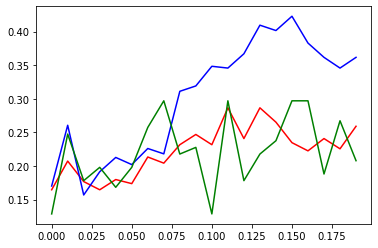

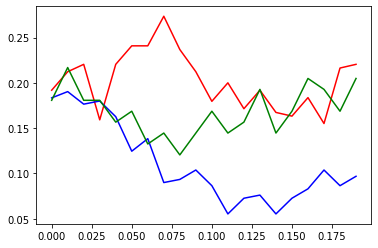

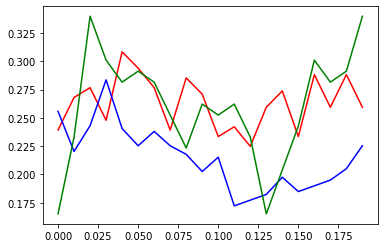

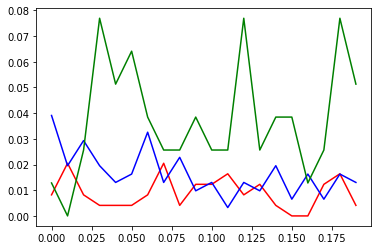

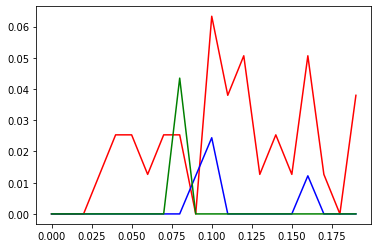

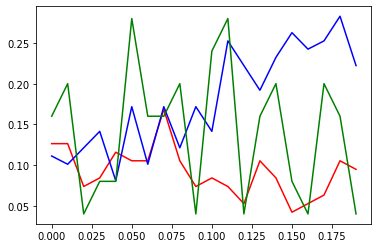

In [296]:
x_ax = np.arange(0,.2,.01)
for i in range(len(temp)):   
    plt.figure()
    plt.plot(x_ax,temp.left_PSTH.iloc[i],'r')
    plt.plot(x_ax,temp.right_PSTH.iloc[i],'b')
    plt.plot(x_ax,temp.zero_PSTH.iloc[i],'g')

/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interfa

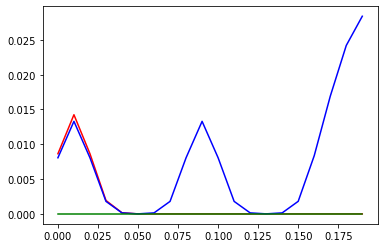

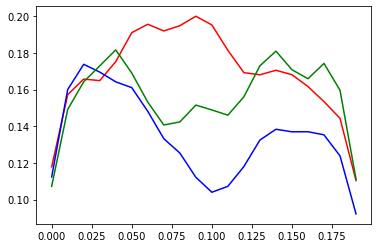

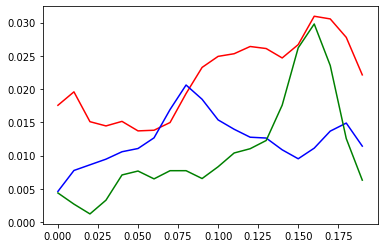

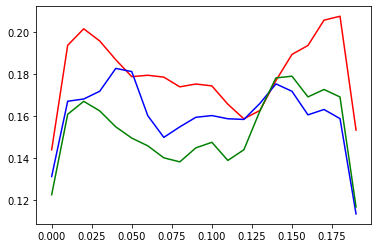

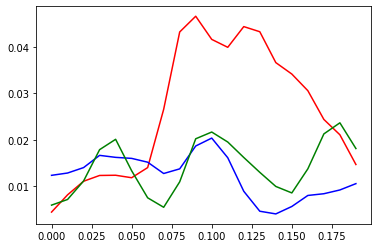

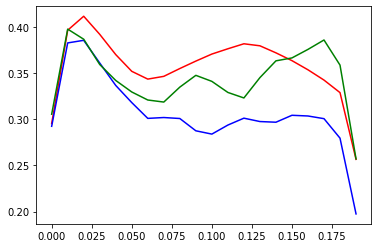

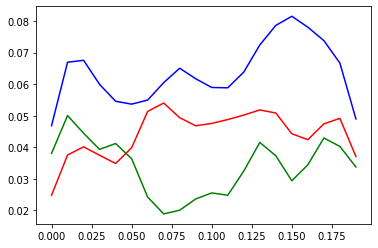

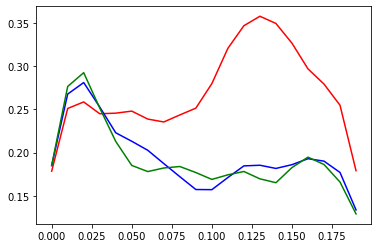

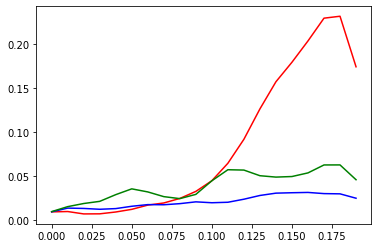

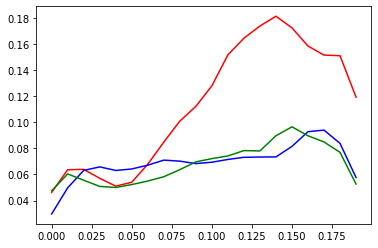

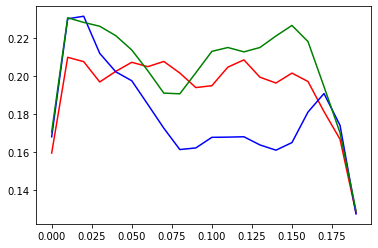

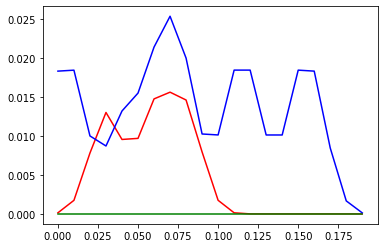

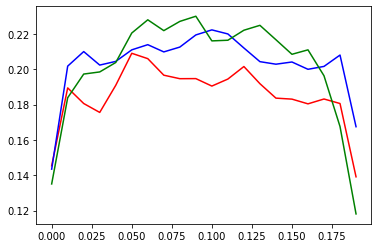

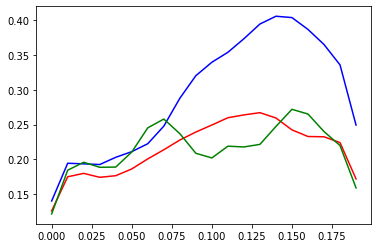

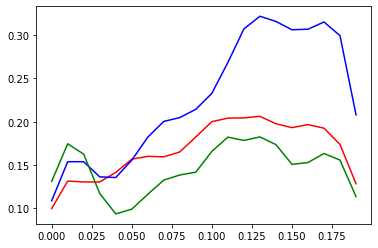

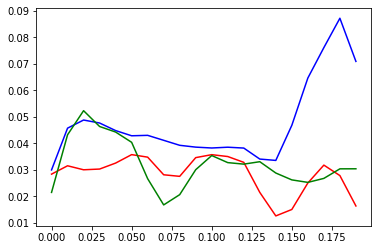

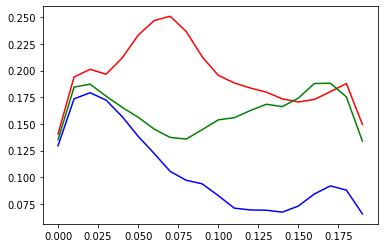

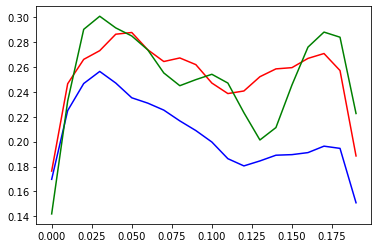

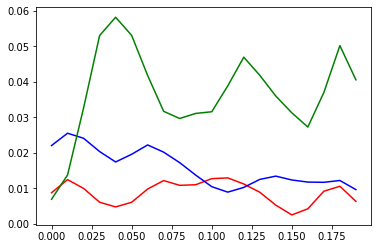

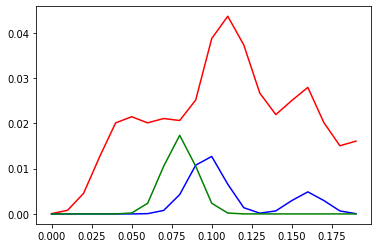

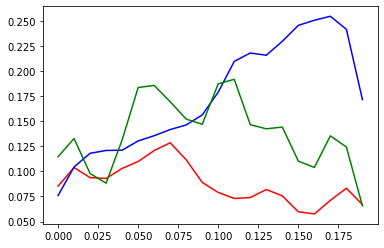

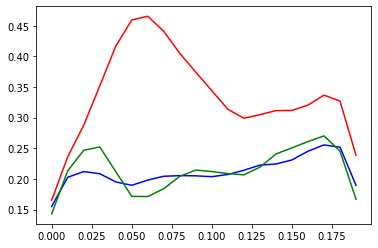

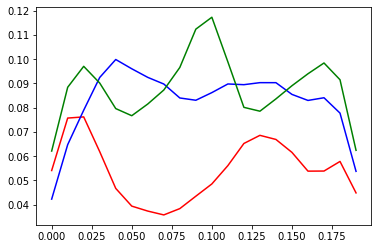

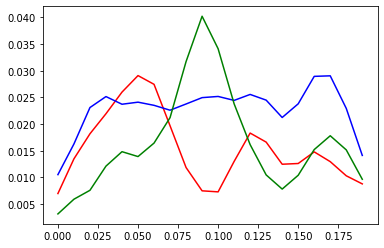

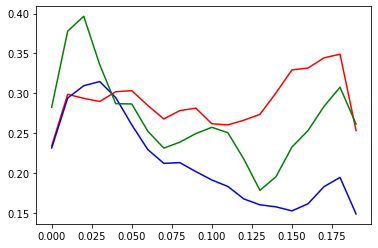

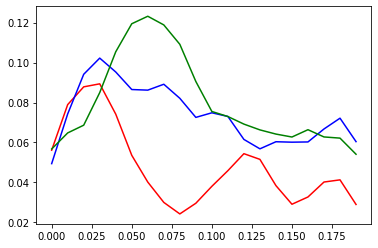

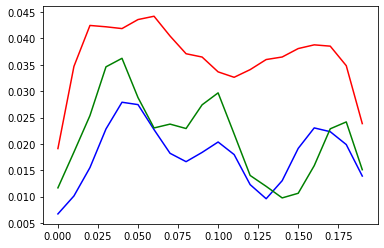

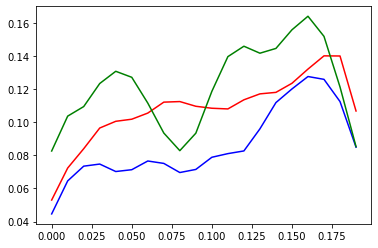

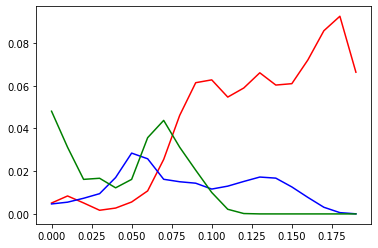

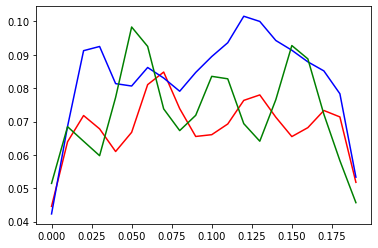

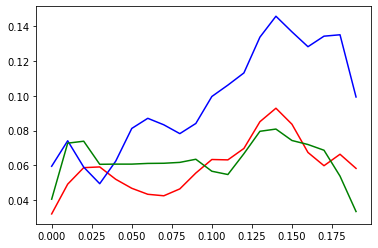

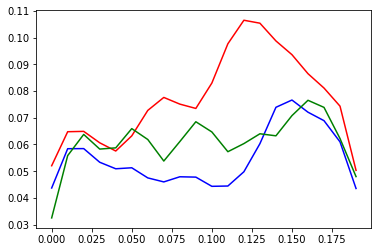

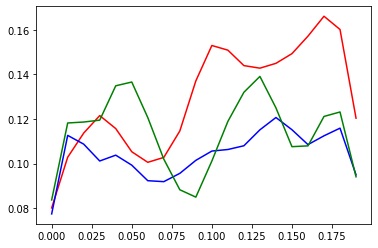

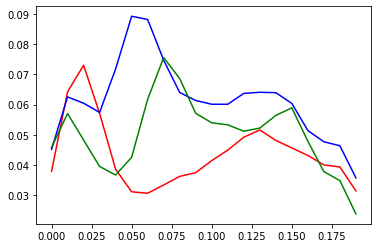

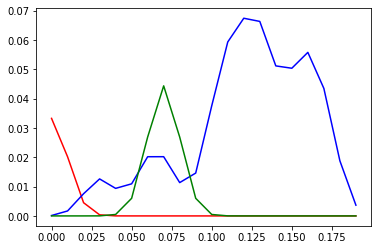

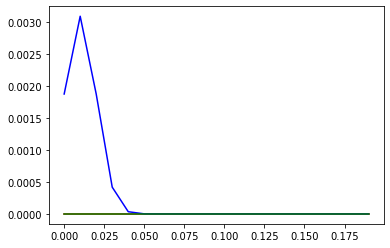

In [341]:
# sig, all_areas = vis_PSTH_from_dj(data.trial_spike_times, data.cluster_id, data.event, data.signedContrast, alpha = .001)
x_ax = np.arange(0,.2,.01)
for i in range(len(sig)):
    plt.figure()
    plt.plot(x_ax,sig.left_PSTH[i],'r')
    plt.plot(x_ax,sig.right_PSTH[i],'b')
    plt.plot(x_ax,sig.zero_PSTH[i],'g')

In [244]:
sig

cluster_id                                          left_PSTH  \
0          77  [0.03636363636363636, 0.07272727272727272, 0.0...   
1         146  [0.0625, 0.1125, 0.1, 0.2, 0.2625, 0.4125, 0.3...   
2         188  [0.1875, 0.1625, 0.1125, 0.1625, 0.1375, 0.187...   
3         307  [0.02564102564102564, 0.01282051282051282, 0.0...   
4         469  [0.0, 0.0125, 0.0125, 0.025, 0.0125, 0.0125, 0...   
5         473  [0.05, 0.0625, 0.0875, 0.075, 0.125, 0.15, 0.2...   
6         478  [0.025, 0.025, 0.025, 0.025, 0.0875, 0.3, 0.27...   
7         554  [0.014084507042253521, 0.04225352112676056, 0....   

                                          right_PSTH  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.12987012987012986, 0.1038961038961039, 0.09...   
2  [0.11688311688311688, 0.12987012987012986, 0.1...   
3  [0.0547945205479452, 0.0547945205479452, 0.068...   
4  [0.025974025974025976, 0.012987012987012988, 0...   
5  [0.15584415584415584, 0.025974025974025976, 0....   
6  [0.06493506493506493, 0.012987012987012988, 0....   
7  [0.0, 0.013513513513513514, 0.0270270270270270...   

                                           zero_PSTH brain_area  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        PoT  
1  [0.16666666666666666, 0.041666666666666664, 0....         LP  
2  [0.08333333333333333, 0.16666666666666666, 0.2...         LP  
3  [0.22727272727272727, 0.13636363636363635, 0.0...        CA1  
4  [0.0, 0.0, 0.08333333333333333, 0.083333333333...         LP  
5  [0.08333333333333333, 0.16666666666666666, 0.0...         LP  
6  [0.0, 0.041666666666666664, 0.0416666666666666...         LP  
7  [0.0, 0.041666666666666664, 0.0, 0.08333333333...         LP

In [148]:
def CSK_PSTH(trials, pre_time=0.2, post_time=0.5, bin_size=0.025, smoothing=0.025):
    bin_num = round((pre_time+post_time)/bin_size)
    event_idx = round(pre_time/bin_size)
    all_counts = np.zeros([bin_num,len(trials)])
    for i in range(len(trials)):        
        counts, bins = np.histogram(trials.trial_spike_times.iloc[i],bins=bin_num,range=[-pre_time,post_time])
        all_counts[:,i] = counts
    PSTH = all_counts.mean(axis=1)
    return PSTH, event_idx

/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarnin

/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarnin

/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarnin

/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ckrasnia/opt/anaconda3/envs/iblenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarnin

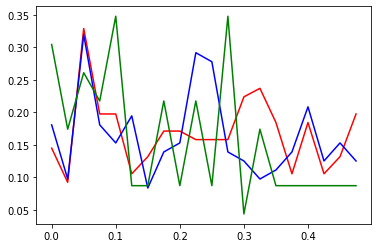

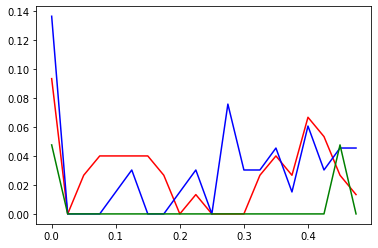

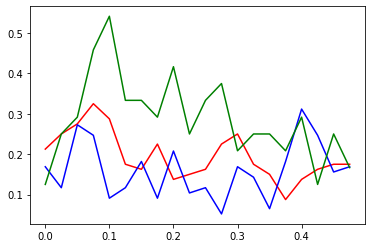

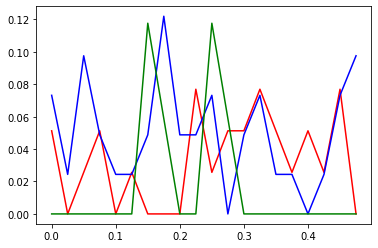

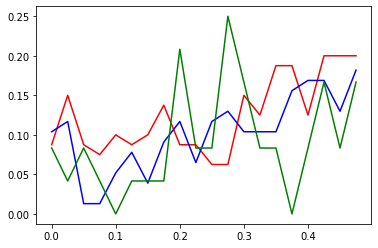

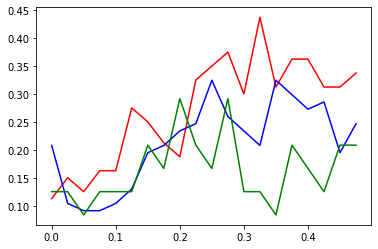

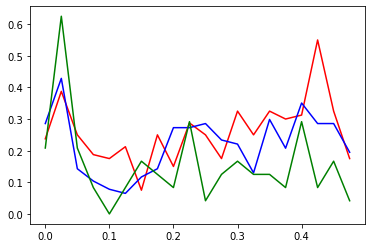

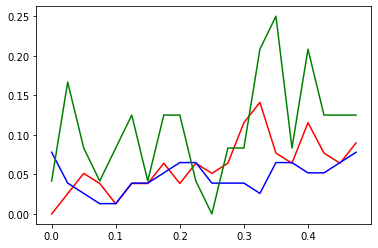

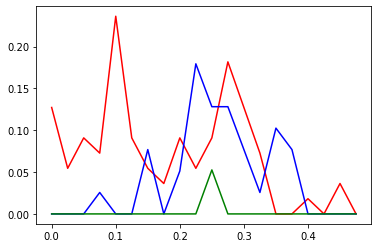

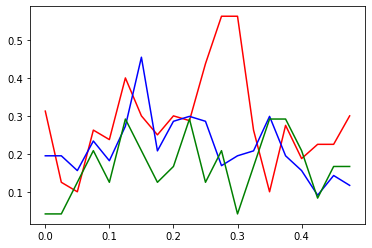

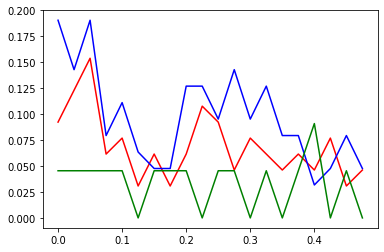

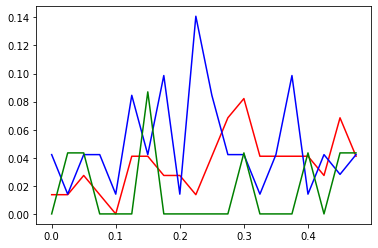

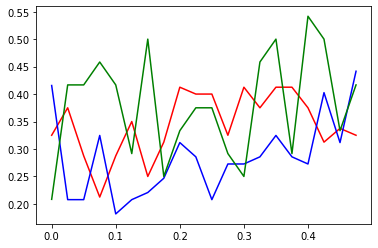

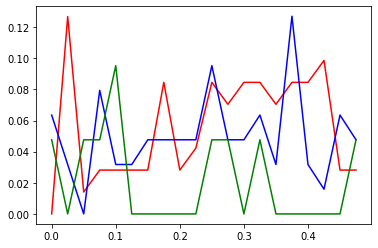

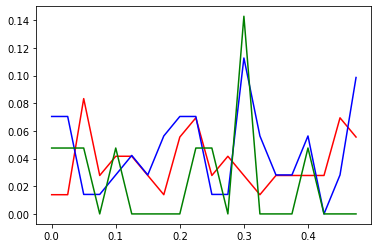

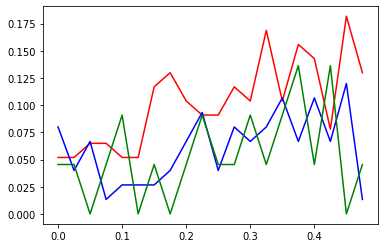

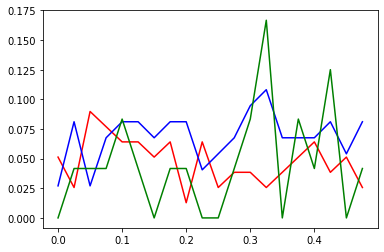

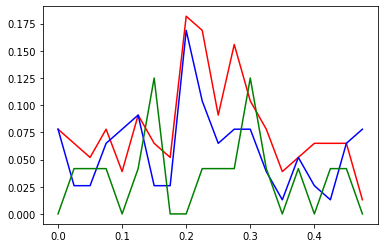

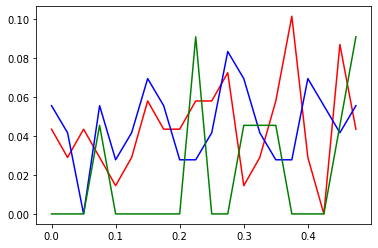

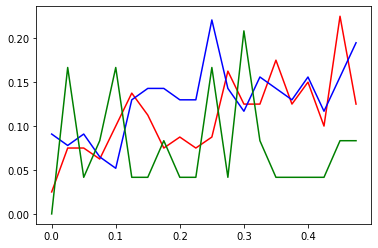

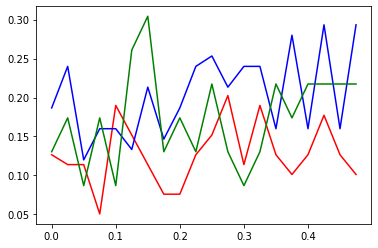

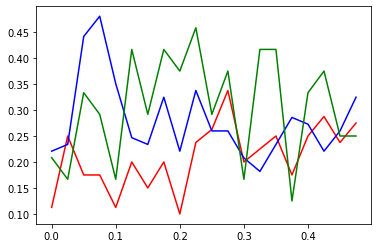

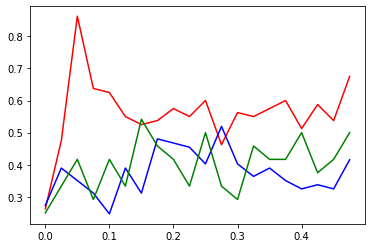

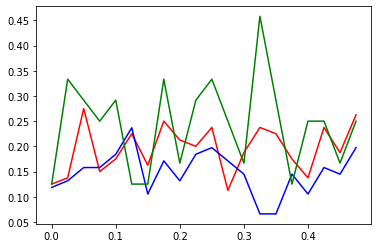

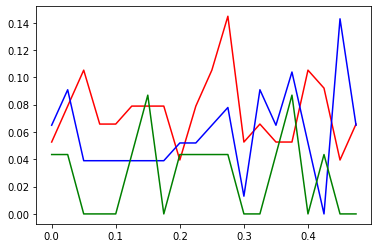

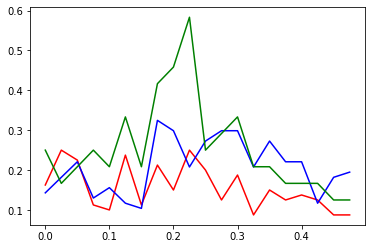

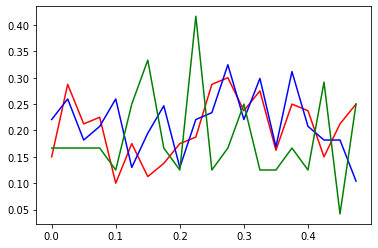

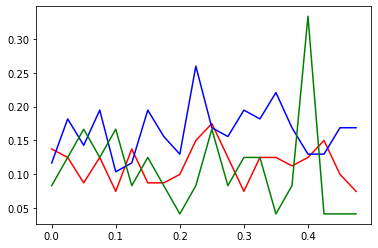

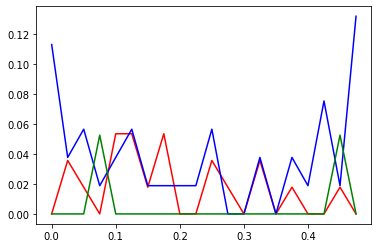

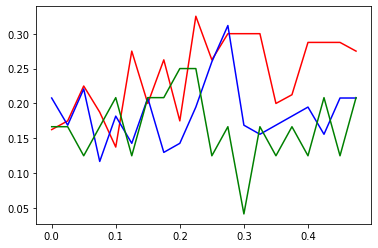

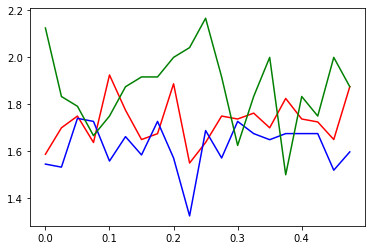

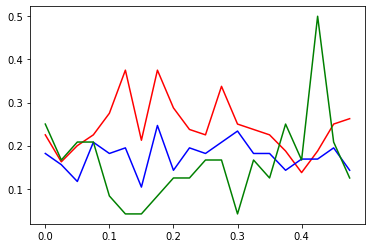

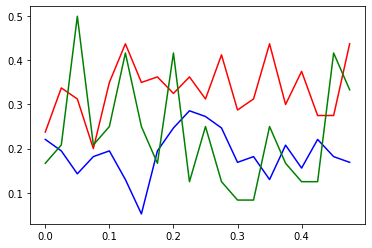

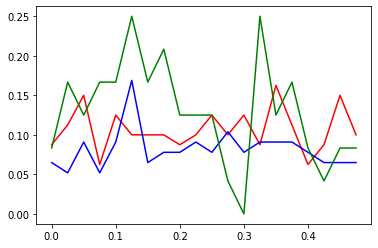

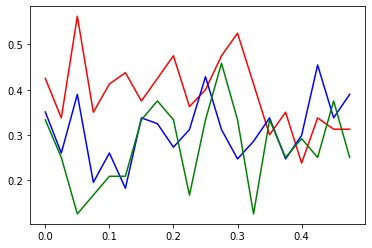

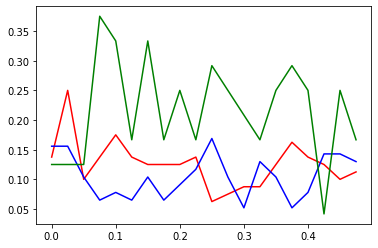

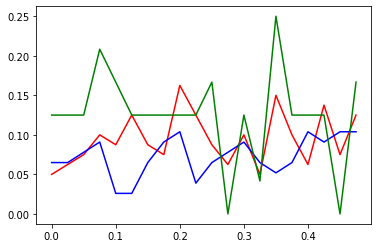

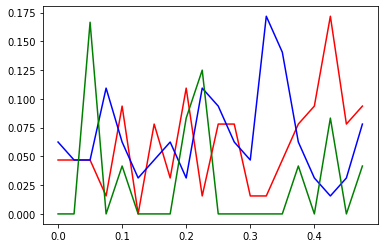

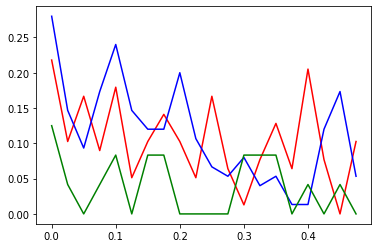

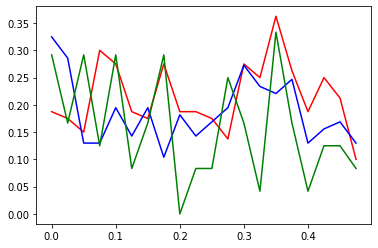

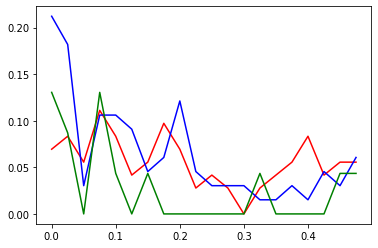

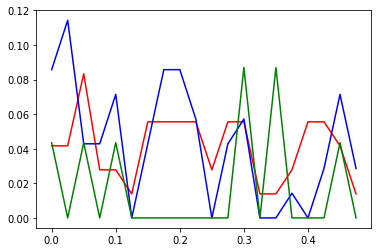

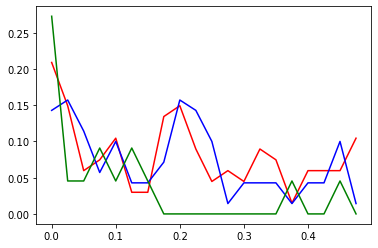

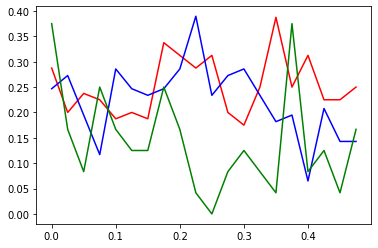

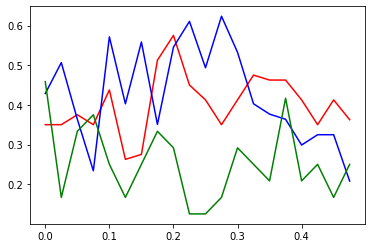

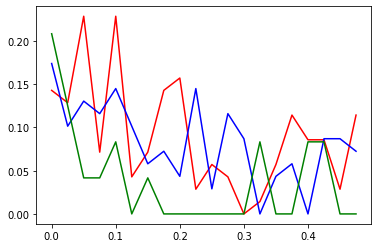

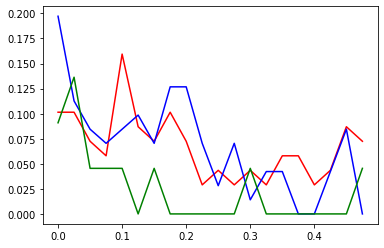

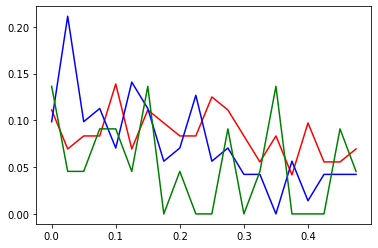

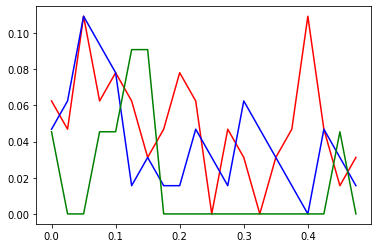

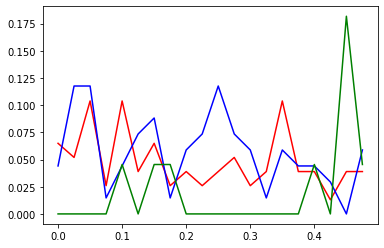

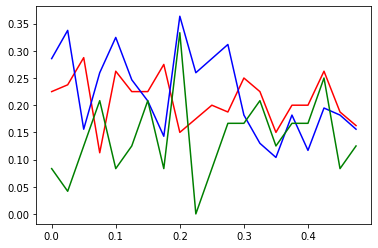

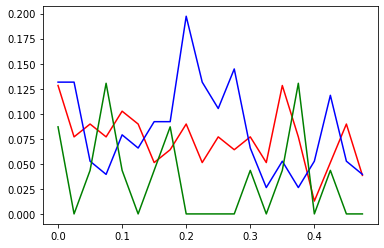

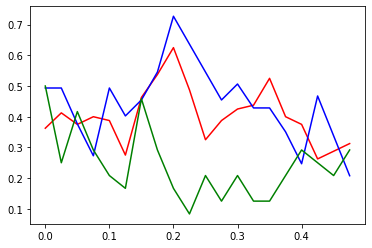

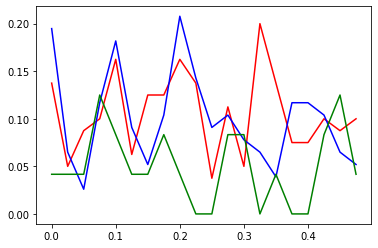

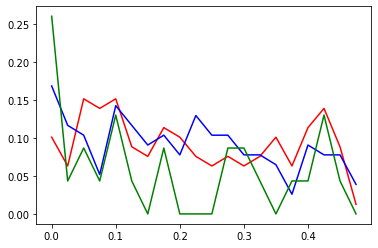

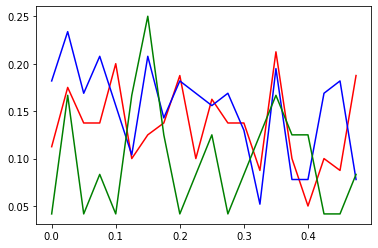

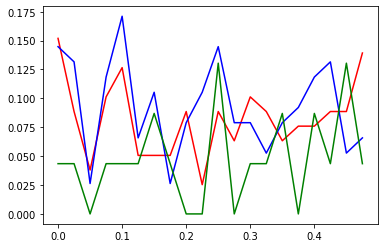

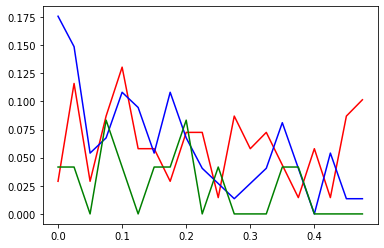

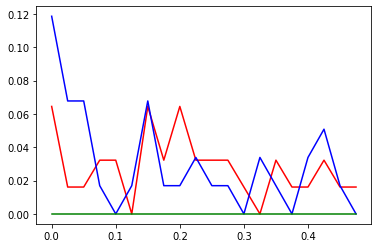

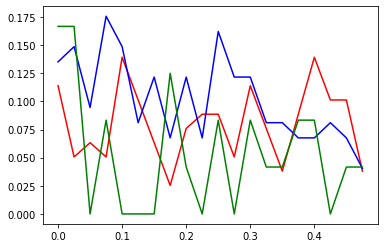

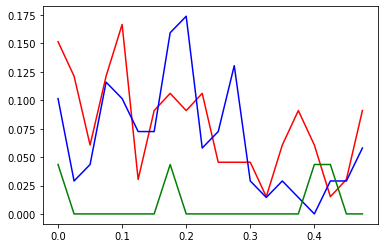

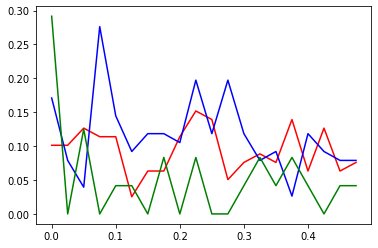

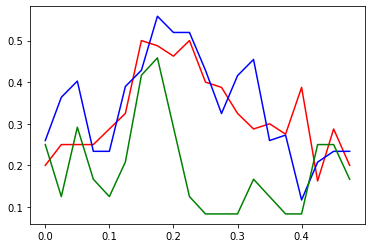

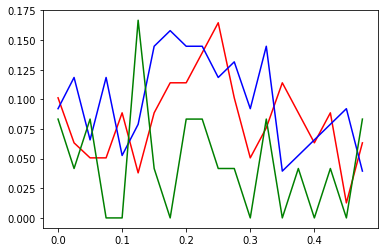

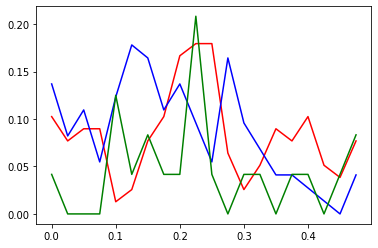

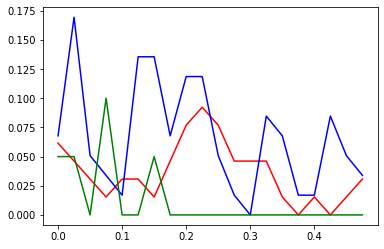

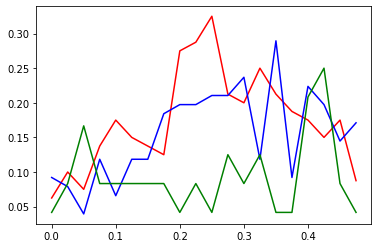

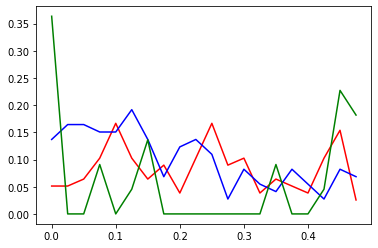

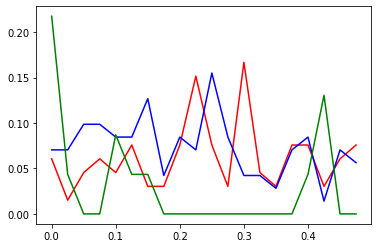

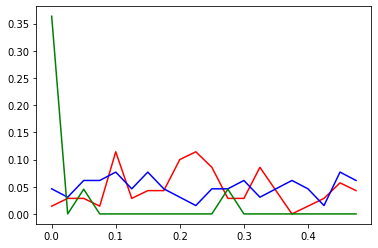

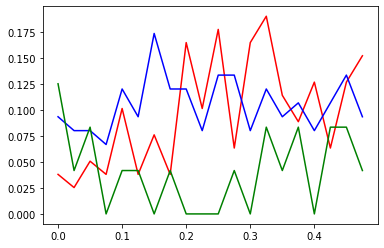

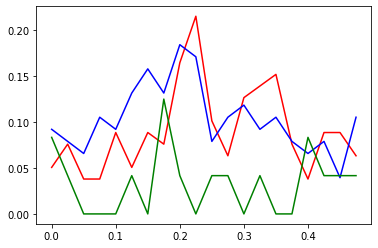

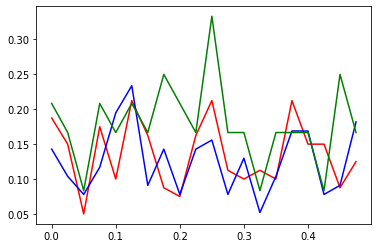

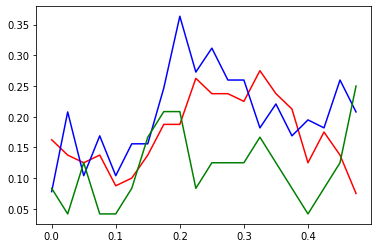

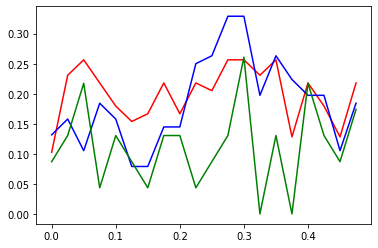

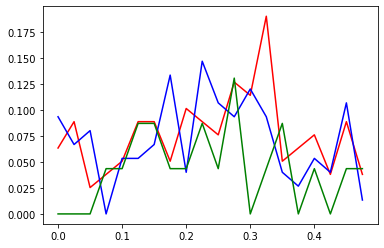

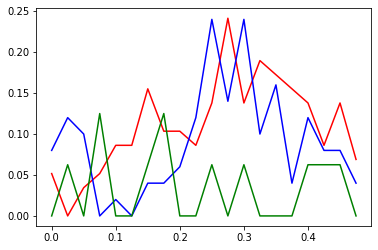

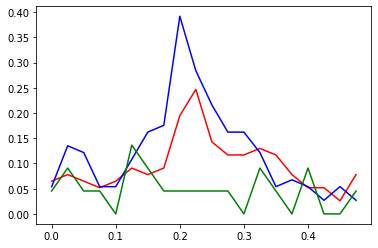

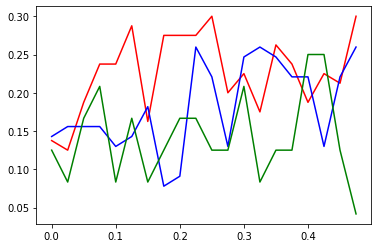

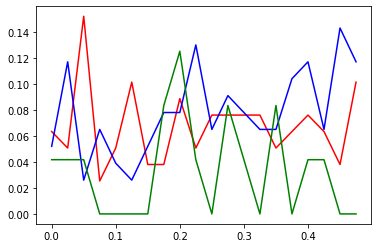

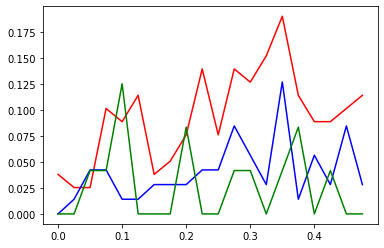

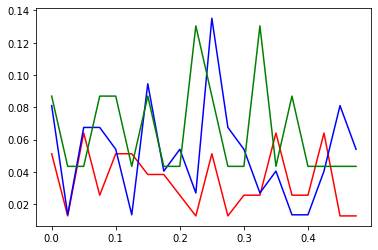

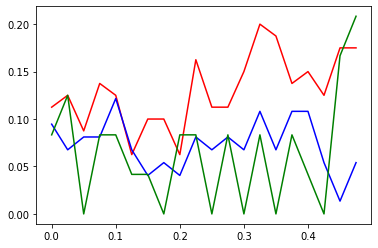

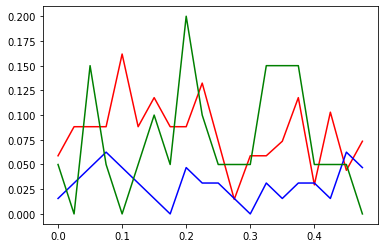

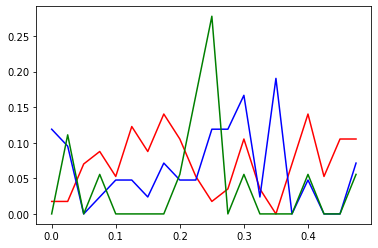

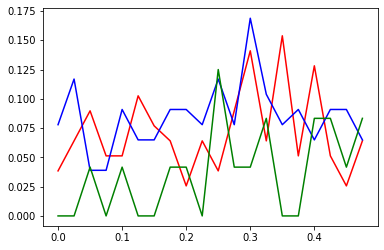

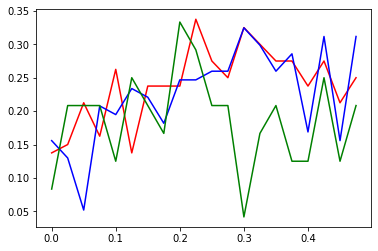

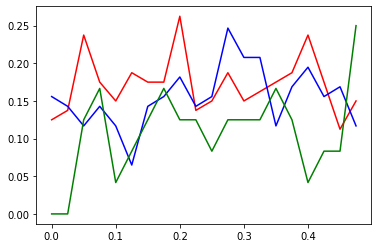

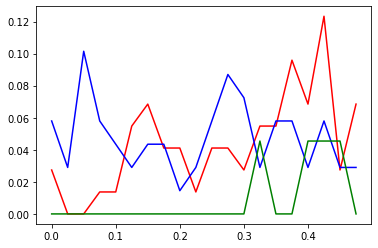

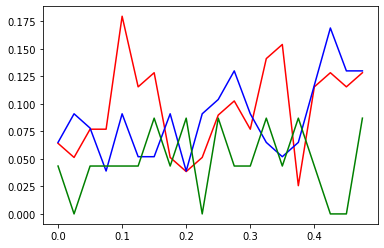

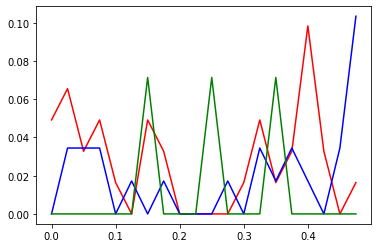

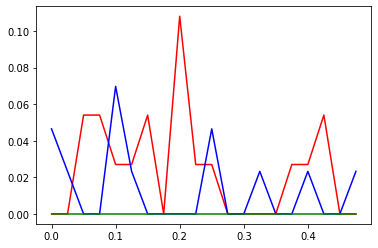

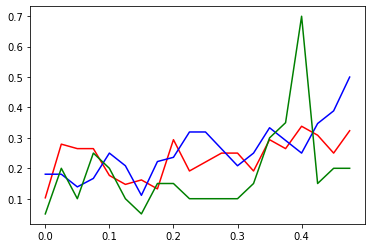

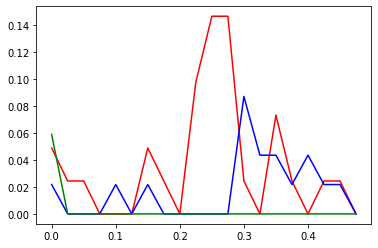

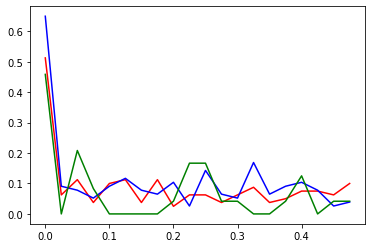

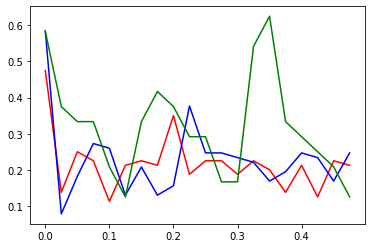

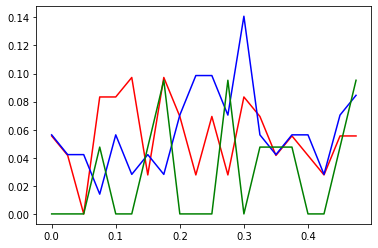

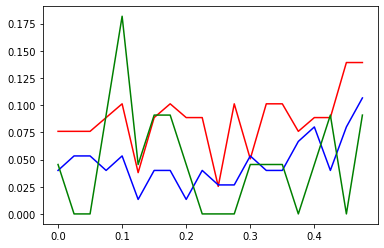

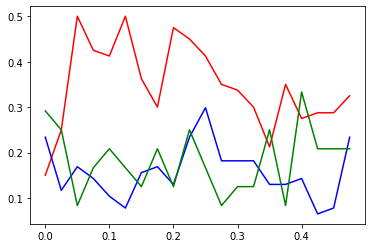

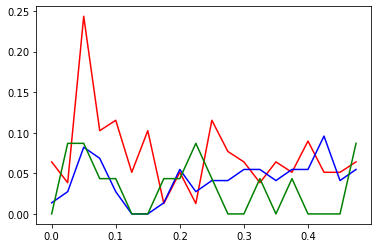

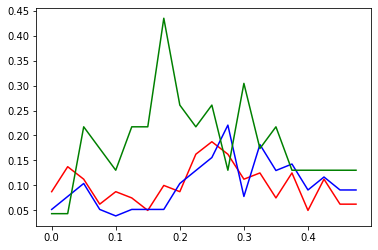

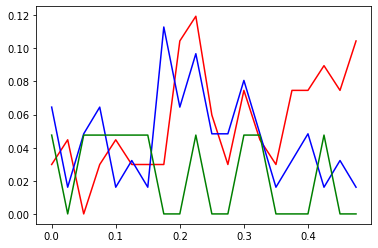

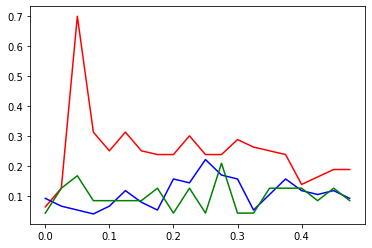

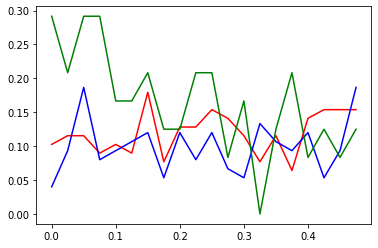

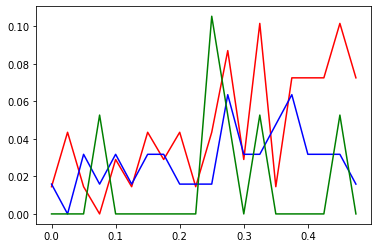

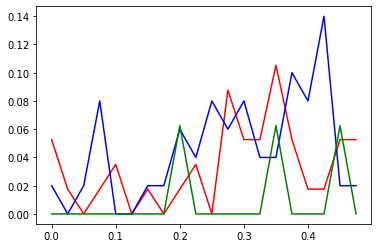

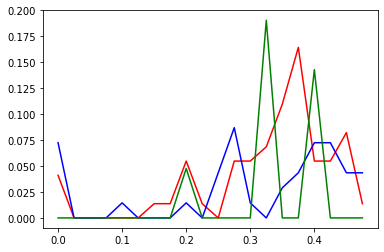

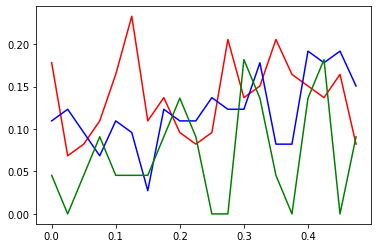

In [238]:
x_ax = np.arange(0,.5,.025)
for i in range(len(sig)):
    plt.figure()
    plt.plot(x_ax,sig.left_PSTH[i],'r')
    plt.plot(x_ax,sig.right_PSTH[i],'b')
    plt.plot(x_ax,sig.zero_PSTH[i],'g')
    

In [375]:
try1 = ephys.AlignedTrialSpikes * subject.Subject & 'subject_nickname = "CSH_ZAD_001"'
try2=pd.DataFrame(try1.fetch(as_dict=True))
try2.trial_spike_times.iloc[:3]

NameError: name 'try12' is not defined

In [376]:
try2.trial_spike_times.iloc[:3]

0    [0.1116946463561419]
1       [1.0272803665016]
2    [1.8788512463578968]
Name: trial_spike_times, dtype: object

In [271]:
temp = (ephys.AlignedTrialSpikes & 'event = "stim on"') * (subject.Subject & 'subject_nickname = "{}"'.format(sub)) * behavior.TrialSet.Trial * (ephys.GoodCluster & 'is_good = "1"') * histology.ClusterBrainRegion & 'insertion_data_source = "Histology track"' 

       

In [272]:
temp

*subject_uuid  *session_start *probe_idx    *cluster_id    *trial_id    *event      *criterion_id  *insertion_dat trial_spik trial_spikes_t subject_nickna sex     subject_birth_ ear_mark     subject_line   subject_source protocol_numbe subject_descri subject_ts     subject_strain trial_start_ti trial_end_time trial_response trial_response trial_stim_on_ trial_stim_con trial_stim_con trial_go_cue_t trial_go_cue_t trial_feedback trial_feedback trial_rep_num  trial_stim_pro trial_reward_v trial_iti_dura trial_included is_good     ontology     acronym    
+------------+ +------------+ +-----------+ +------------+ +----------+ +---------+ +------------+ +------------+ +--------+ +------------+ +------------+ +-----+ +------------+ +----------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +---------+ +----------+ +---------+
18a54f60-534b- 2019-12-03 15: 0             0              1            stim on     1              Histology trac =BLOB=     2020-07-18 18: KS014          M       2019-04-30     None         C57BL/6J       None           3              None           2019-08-06 21: C57BL/6J       15.46320172158 17.42180350233 16.4219        CW             16.16139772769 1.0            0.0            16.1625        16.1616        16.42190469656 1              None           0.5            1.5            1.4999         None           1           CCF 2017     SNc        
18a54f60-534b- 2019-12-03 15: 0             0              2            stim on     1              Histology trac =BLOB=     2020-07-18 18: KS014          M       2019-04-30     None         C57BL/6J       None           3              None           2019-08-06 21: C57BL/6J       18.39410510107 24.79272419890 23.7928        CW             19.65934371993 0.125          0.0            19.6571        19.6562        23.79282539312 1              None           0.5            1.5            1.4999         None           1           CCF 2017     SNc        
18a54f60-534b- 2019-12-03 15: 0             0              3            stim on     1              Histology trac =BLOB=     2020-07-18 18: KS014          M       2019-04-30     None         C57BL/6J       None           3              None           2019-08-06 21: C57BL/6J       25.76412588871 28.72832589843 27.7284        CW             25.99330269499 1.0            0.0            27.029         27.028         27.72842709265 1              None           0.5            1.5            1.4999         None           1           CCF 2017     SNc        
18a54f60-534b- 2019-12-03 15: 0             0              4            stim on     1              Histology trac =BLOB=     2020-07-18 18: KS014          M       2019-04-30     None         C57BL/6J       None           3              None           2019-08-06 21: C57BL/6J       29.68072951093 37.11947667649 35.1194        CW             30.99426324211 0.0            0.0625         30.9953        30.9944        35.12021234430 -1             None           0.5            0.0            2.5            None           1           CCF 2017     SNc        
18a54f60-534b- 2019-12-03 15: 0             0              5            stim on     1              Histology trac =BLOB=     2020-07-18 18: KS014          M       2019-04-30     None         C57BL/6J       None           3              None           2019-08-06 21: C57BL/6J       38.11707571501 42.29518620490 41.2953        CW             40.89922748216 0.25           0.0            40.8871        40.8863        41.29528739912 1              None           0.5            1.5            1.4999         None           1           CCF 2017     SNc        
18a54f60-534b- 2019-12-03 15: 0             0              6            stim on     1         

In [ ]:
df